In [1]:
import requests 
import json
from pprint import pprint
import os
import pandas as pd
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
import gmaps
from scipy.stats import sem
from scipy.stats import linregress
from config import Q1api_key
from config import Q1_GKey

In [2]:
# # Import Merged GDP and Weather data
merge_path = os.path.join("Resources", "Merge_data_2005-2015.csv")
merge_df = pd.read_csv(merge_path)

merge_df.head()

,Unnamed: 0,ISO3,Country,Year,Temp_Farenheit,Rainfall_mm,GDP,GDP_md,GDP_bd
0,0,AFG,Afghanistan,2005,56.087945,29.609967,6.209138e+09,6209.137625,6.209138
1,1,AFG,Afghanistan,2006,57.501470,27.120458,6.971286e+09,6971.285595,6.971286
2,2,AFG,Afghanistan,2007,56.320054,25.329681,9.747880e+09,9747.879532,9.747880
3,3,AFG,Afghanistan,2008,56.755070,21.505365,1.010923e+10,10109.225814,10.109226
4,4,AFG,Afghanistan,2009,56.807912,31.106477,1.243909e+10,12439.087077,12.439087


In [3]:
# # Understand the data
max_Temp = merge_df['Temp_Farenheit'].max()
min_Temp = merge_df['Temp_Farenheit'].min()
print(f"Maximum temperature in data is {max_Temp}")
print(f"Minimum temperature in data is {min_Temp}")

max_GDP = merge_df['GDP_bd'].max()
min_GDP = merge_df['GDP_bd'].min()
print(f"Maximum GDP in data is {max_GDP}")
print(f"Minimum GDP in data is {min_GDP}")

Maximum temperature in data is 85.173935
Minimum temperature in data is 0.8050399999999988
Maximum GDP in data is 18219.3
Minimum GDP in data is 0.02183909889


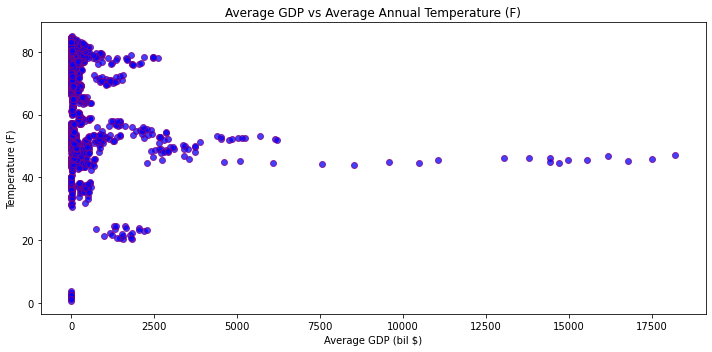

In [4]:
# # Plot all the data
# Plot the Temperature versus GDP data to look for trend/features to investigate
ListofISO34Plot = merge_df['ISO3']
# # Make Scatter plot of Temperature vs GDP  
plt.figure(figsize=(10,5))
plt.scatter(merge_df["GDP_bd"], merge_df["Temp_Farenheit"], marker='o', facecolor='b', edgecolors='purple', alpha = 0.75)
plt.title(f"Average GDP vs Average Annual Temperature (F)")
plt.xlabel("Average GDP (bil $)")
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("output_data/Q1/Fig1_AvTemp_vs_GDP_AllCountries.png")
plt.show()

In [5]:
# Crop data to area of interest
zone1_df = merge_df.loc[(merge_df['Temp_Farenheit']>=40) & (merge_df['Temp_Farenheit']<=60)]
zone1_df

zone2_df = merge_df.loc[(merge_df['Temp_Farenheit']>=70) & (merge_df['Temp_Farenheit']<=86)]
zone2_df

zone3_df = merge_df.loc[(merge_df['Temp_Farenheit']>=18) & (merge_df['Temp_Farenheit']<=28)]
zone3_df

# Create a merged (zone1, 2 & 3) dataframe
ZONE_df = merge_df.loc[(merge_df['Temp_Farenheit']>=18) & (merge_df['Temp_Farenheit']<=28) | (merge_df['Temp_Farenheit']>=40) & (merge_df['Temp_Farenheit']<=60) | (merge_df['Temp_Farenheit']>=70) & (merge_df['Temp_Farenheit']<=86)]
ZONE_df = ZONE_df.dropna(how='any')


# # Understand the data
ZoneCountries = merge_df['ISO3'].nunique()
print(f"No. of countries after filter {ZoneCountries}")

ZONE_df

No. of countries after filter 188


,Unnamed: 0,ISO3,Country,Year,Temp_Farenheit,Rainfall_mm,GDP,GDP_md,GDP_bd
0,0,AFG,Afghanistan,2005,56.087945,29.609967,6.209138e+09,6209.137625,6.209138
1,1,AFG,Afghanistan,2006,57.501470,27.120458,6.971286e+09,6971.285595,6.971286
2,2,AFG,Afghanistan,2007,56.320054,25.329681,9.747880e+09,9747.879532,9.747880
3,3,AFG,Afghanistan,2008,56.755070,21.505365,1.010923e+10,10109.225814,10.109226
4,4,AFG,Afghanistan,2009,56.807912,31.106477,1.243909e+10,12439.087077,12.439087
...,...,...,...,...,...,...,...,...,...
2063,2140,ZWE,Zimbabwe,2011,71.085215,63.126104,1.410192e+10,14101.920300,14.101920
2064,2141,ZWE,Zimbabwe,2012,71.438135,45.312368,1.711485e+10,17114.849900,17.114850
2065,2142,ZWE,Zimbabwe,2013,70.923830,51.234424,1.909102e+10,19091.020000,19.091020
2066,2143,ZWE,Zimbabwe,2014,71.078870,50.608135,1.949552e+10,19495.519600,19.495520


In [6]:
# # LOOKING FOR REGRESSIONS
# Looking at the trend line for temperature over time (10yrs) for each country and GDP over time for 
# the same country storing these values to compare them.

# FOR COMBINED ZONES OF INTEREST
# Initialize lists and dictionairies needed
ListofISO3_Merged = merge_df['ISO3']
ZONERegressList = []
ZONERegressDictGDP = {}
ZONERegressDictTemp = {}
ZONEPvalueDictGDP = {}
ZONEPvalueDictTemp = {}
R_ValuesGDP = {}
R_ValuesTemp = {}
P_ValuesGDP = {}
P_ValuesTemp = {}

# Run for-loop to get regression values for GDP for each country (store rvalue & pvalue)
for ISO in ListofISO3_Merged:
    ZONECorrelation_df = merge_df.loc[merge_df['ISO3']== ISO]
    GDP = ZONECorrelation_df['GDP']
    Yrs = ZONECorrelation_df['Year']    

    #  LINEAR REGRESSION MODEL 
    # Run the regression and store each of the returned values
    slope, intercept, rvalue, pvalue, stderr = linregress(Yrs, GDP)
    Zone_regression = [slope, intercept, rvalue, pvalue, stderr]
    Zone_Rvalue = Zone_regression[2]
    Zone_Pvalue = Zone_regression[3]
    ZONERegressDictGDP[ISO] = Zone_Rvalue
    ZONEPvalueDictGDP[ISO] = Zone_Pvalue
R_ValuesGDP = ZONERegressDictGDP
P_ValuesGDP = ZONEPvalueDictGDP

# Run for-loop to get regression values for annual average Temperature for each country (store rvalue & pvalue)
for ISO in ListofISO3_Merged:
    ZONECorrelation_df = merge_df.loc[merge_df['ISO3']== ISO]
    Temps = ZONECorrelation_df['Temp_Farenheit']
    Yrs = ZONECorrelation_df['Year']    

    #  LINEAR REGRESSION MODEL 
    # Run the regression and store each of the returned values
    slope, intercept, rvalue, pvalue, stderr = linregress(Yrs, Temps)
    Zone_regression = [slope, intercept, rvalue, pvalue, stderr]
    Zone_Rvalue = Zone_regression[2]
    Zone_Pvalue = Zone_regression[3]
    ZONERegressDictTemp[ISO] = Zone_Rvalue
    ZONEPvalueDictTemp[ISO] = Zone_Pvalue
R_ValuesTemp = ZONERegressDictTemp
P_ValuesTemp = ZONEPvalueDictTemp

In [7]:
# # COMPARING REGRESSION VALUES FOR GDP AND TEMPERATURE
# Looking at the difference between the r-value for the GDP trend line and the annual temperature of a given 
# country would help ascertain any relationship.
# For example, a high, positive r-value for the GDP trend line and a smiliarly high, positive r-value for the 
# annual temperature trend line indicates the possibility of a correlation.
# This is only done on countries with significant p-value #'s for GDP and temperature (alpha of 0.1 was chosen)

# Create a df to look at the GDP and Temperature regressions
RegressList ={"TEMP_REGRESS": R_ValuesTemp,"GDP_REGRESS": R_ValuesGDP, "TEMP_PVALUE": P_ValuesTemp,"GDP_PVALUE": P_ValuesGDP}
Regress_df = pd.DataFrame(RegressList)
Regress_df = Regress_df.reset_index()
Regress_df = Regress_df.rename(columns={'index': 'ISO3'})
Regress_df['Regression_diff'] = Regress_df['TEMP_REGRESS'] - Regress_df['GDP_REGRESS']
Regress_df = Regress_df.sort_values(by='GDP_PVALUE', ascending=True)
Regress_df

# DIVING DEEPER
#  Only look at data with a statistically significant p-value (p-value < alpha)
step1_df = Regress_df.loc[(Regress_df['TEMP_PVALUE']<=0.1) & (Regress_df['GDP_PVALUE']<=0.1)]
# Within this subset, look for countries that show a high positive correlation (Low regression difference value ~0)
Regress_Subset_Pos_df = step1_df.loc[(Regress_df['Regression_diff']>=-0.2) & (Regress_df['Regression_diff']<=0.2)]
# Within this subset, look for countries that show a high inverse correlation (High regression difference value ~+2 or -2)
Regress_Subset_Inv_df = step1_df.loc[((Regress_df['Regression_diff']>=1.1) | (Regress_df['Regression_diff']<=-1.6))]


# # MAKE POS & INV CORRELATED LISTS OF COUNTRIES TO RUN GRAPHING CODE IN NEXT CELL
RegressSubsetListPos = Regress_Subset_Pos_df['ISO3']
RegressSubsetListInv = Regress_Subset_Inv_df['ISO3']
RegressSubsetList = []
RegressSubsetList.append(RegressSubsetListPos)
RegressSubsetList.append(RegressSubsetListInv)
RegressSubsetNo = (Regress_Subset_Pos_df['ISO3'].nunique()) + (Regress_Subset_Inv_df['ISO3'].nunique())
print(f"No. of countries after filter {RegressSubsetNo}")
RegressSubsetList

# # Understand the max and min of the temperature regresssion data
maxTempRegression = Regress_df['TEMP_REGRESS'].max()
minTempRegression = Regress_df['TEMP_REGRESS'].min()
print(f"Max temperature regression value in data is {round(maxTempRegression,4)}")
print(f"Min temperature regression value in data is {round(minTempRegression,4)}")
# # Understand the max and min of the GDP regresssion data
maxGDPRegression = Regress_df['GDP_REGRESS'].max()
minGDPRegression = Regress_df['GDP_REGRESS'].min()
print(f"Max GDP regression value in data is {round(maxGDPRegression,4)}")
print(f"Min GDP regression value in data is {round(minGDPRegression,4)}")
# # Understand the max and min of the temperature p-value data
maxTempPVal = Regress_df['TEMP_PVALUE'].max()
minTempPVal = Regress_df['TEMP_PVALUE'].min()
print(f"Max temperature P value in data is {round(maxTempPVal,4)}")
print(f"Min temperature P value in data is {round(minTempPVal,4)}")
# # Understand the max and min of the GDP p-value data
maxGDPPVal = Regress_df['GDP_PVALUE'].max()
minGDPPVal = Regress_df['GDP_PVALUE'].min()
print(f"Max GDP P value in data is {round(maxGDPPVal,4)}")
print(f"Min GDP P value in data is {round(minGDPPVal,4)}")
# # Understand the max and min of the regresssion difference data
maxRegressionDiff = Regress_df['Regression_diff'].max()
minRegressionDiff = Regress_df['Regression_diff'].min()
print(f"Max regression difference in data is {round(maxRegressionDiff,4)}")
print(f"Min regression difference in data is {round(minRegressionDiff,4)}")

# Regress_df

No. of countries after filter 17
Max temperature regression value in data is 0.8523
Min temperature regression value in data is -0.7391
Max GDP regression value in data is 0.9966
Min GDP regression value in data is -0.5981
Max temperature P value in data is 1.0
Min temperature P value in data is 0.0009
Max GDP P value in data is 0.9972
Min GDP P value in data is 0.0
Max regression difference in data is 1.1004
Min regression difference in data is -1.7099


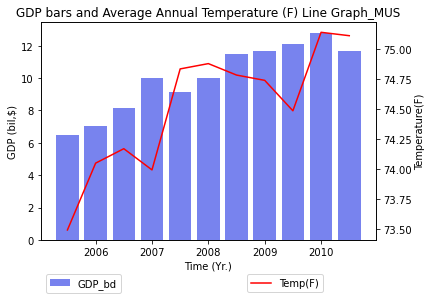

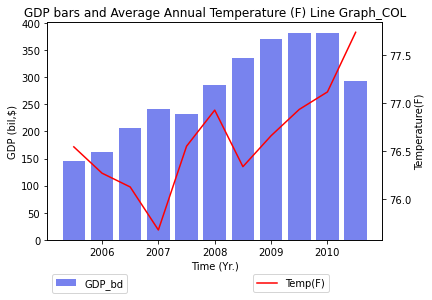

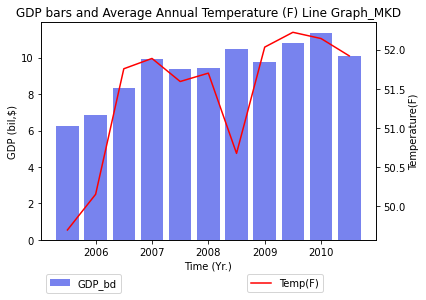

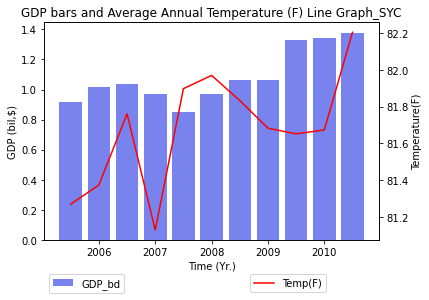

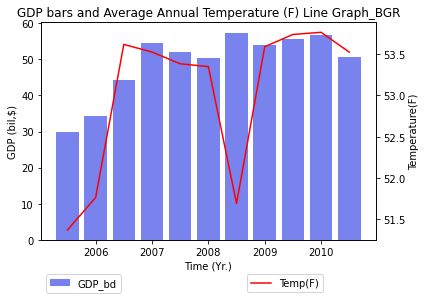

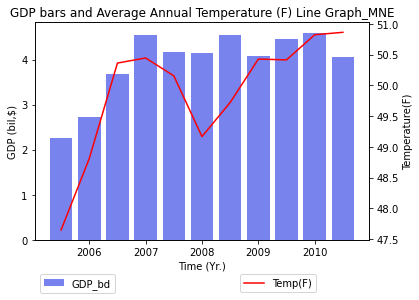

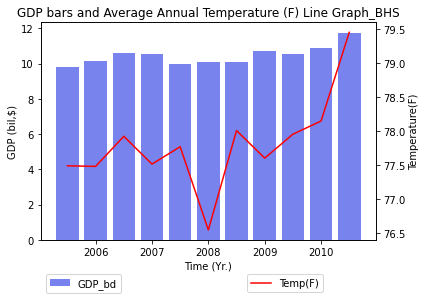

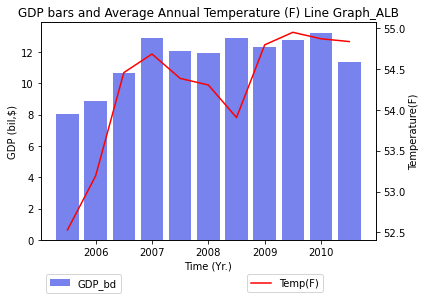

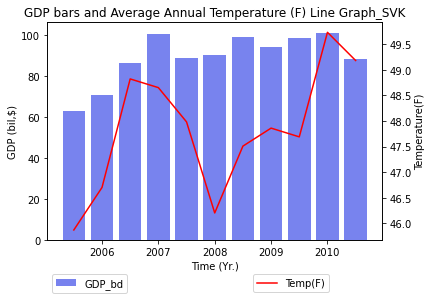

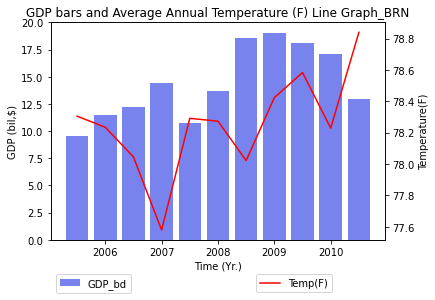

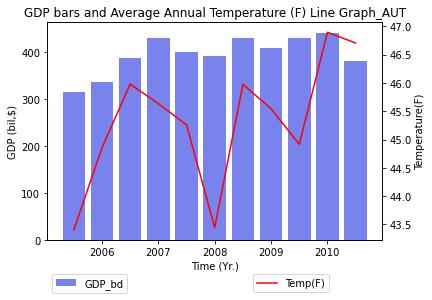

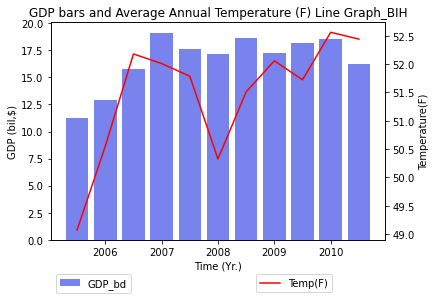

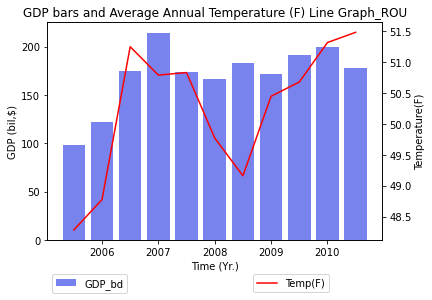

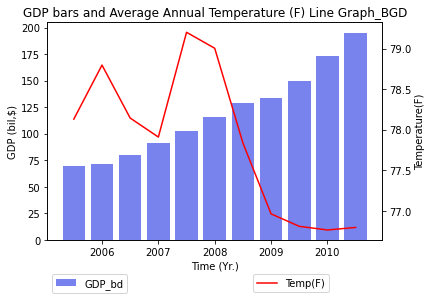

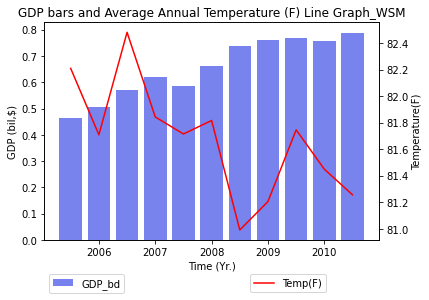

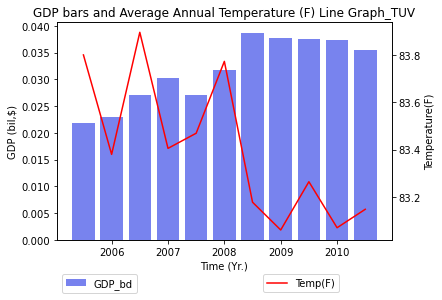

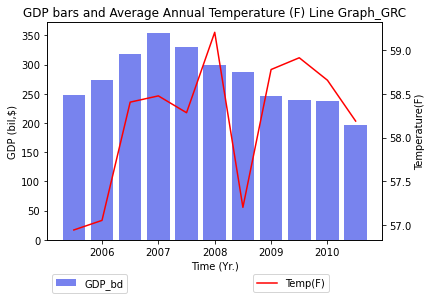

In [8]:
# # DUAL AXIS BAR/LINE CHART FOR COUNTRIES SHOWING A SIGNIFICANT RELATIONSHIP
# A bar chart/line graph to compare GDP and annual temperature trends over time.
# POSITIVE CORRELATION SUBSET
for ISO in RegressSubsetListPos:
    BarGraph_df = merge_df.loc[merge_df['ISO3']== ISO]
    yearList = BarGraph_df['Year'].unique()
    yearNo = np.array(range(len(yearList)))
    GDPNos = BarGraph_df['GDP_bd']
    TempNos = BarGraph_df['Temp_Farenheit']
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(yearList, GDPNos, color=(63/255,79/255,232/255,0.7), label='GDP_bd')
    ax2.plot(yearList, TempNos, color='red', label='Temp(F)')
    ax.set_xticklabels(yearList)
    ax.legend(loc='center left', bbox_to_anchor=(0, -0.2))
    ax2.legend(loc='center left', bbox_to_anchor=(0.6, -0.2))
    ax.set_title(f"GDP bars and Average Annual Temperature (F) Line Graph_{ISO}")
    ax.set_ylabel('GDP (bil,$)')
    ax2.set_ylabel('Temperature(F)')
    ax.set_xlabel('Time (Yr.)')
    plt.savefig(f"output_data/Q1/Fig2_GDP_BarChart_TempLineChart_{ISO}_2005-2015.png")

# INVERSE CORRELATION SUBSET
for ISO in RegressSubsetListInv:
    BarGraph_df = merge_df.loc[merge_df['ISO3']== ISO]
    yearList = BarGraph_df['Year'].unique()
    yearNo = np.array(range(len(yearList)))
    GDPNos = BarGraph_df['GDP_bd']
    TempNos = BarGraph_df['Temp_Farenheit']
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(yearList, GDPNos, color=(63/255,79/255,232/255,0.7), label='GDP_bd')
    ax2.plot(yearList, TempNos, color='red', label='Temp(F)')
    ax.set_xticklabels(yearList)
    ax.legend(loc='center left', bbox_to_anchor=(0, -0.2))
    ax2.legend(loc='center left', bbox_to_anchor=(0.6, -0.2))
    ax.set_title(f"GDP bars and Average Annual Temperature (F) Line Graph_{ISO}")
    ax.set_ylabel('GDP (bil,$)')
    ax2.set_ylabel('Temperature(F)')
    ax.set_xlabel('Time (Yr.)')
    plt.savefig(f"output_data/Q1/Fig2_GDP_BarChart_TempLineChart_{ISO}_2005-2015.png")


In [9]:
# Lat long of capital cities of correlated countries
# CorrCountriesList = []
MUS = (-20.2, 57.5)
COL = (4.583333, -74.066667)
MKD = (42, 21.433333)
SYC = (-4.616667, 55.45)
BGR = (42.683333, 23.316667)
MNE = (42.783333, 19.466667)
BHS = (25.066667, -77.333333)
ALB = (41.316667, 19.816667)
SVK = (48.15, 17.116667)
BRN = (4.890283, 114.942217)
AUT = (48.2, 16.35)
BIH = (43.866667, 18.416667)
ROU = (44.416667, 26.1)
BGD = (23.763889, 90.388889)
WSM = (-13.833333, -171.75)
TUV = (-8.516667, 179.2)
GRC = (37.966667, 23.716667)
AND = (42.5, 1.516667)
MNP = (15.19, 145.74)
DOM = (19, -70.666667)
GRC = (37.966667, 23.716667)
CAF = (4.366667, 18.583333)
PosCorrCountriesList = [BGD, WSM, TUV, GRC]
InvCorrCountriesList = [MUS, COL, MKD, SYC, BGR, MNE, BHS, ALB, SVK, BRN, AUT, BIH, ROU]


In [10]:
# CREATE A GEOMAP
# STEP 1 ---------------------------------------------------------
# SET UP LAT LONG PAIRS
Coords = InvCorrCountriesList
Coords

fig = gmaps.figure()

# Create a marker layer using our coordinates
markers = gmaps.marker_layer(Coords)

# Add the layer to the map
fig.add_layer(markers)

# display the figure with the newly added layer
fig

Figure(layout=FigureLayout(height='420px'))